<a href="https://colab.research.google.com/github/MominaSiddiq/bert-sentiment-analysis/blob/main/Bert_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [ ]:
# ✅ Install core libraries with compatible versions
!pip install -q transformers==4.53.0 datasets accelerate fsspec==2023.6.0


In [ ]:
!pip install numpy==1.26.4 --force-reinstall
import os
os.kill(os.getpid(), 9)

# Imports


In [43]:
# Import essential libraries for working with transformers and datasets
from datasets import load_dataset                    # For loading the IMDb dataset
from transformers import (BertTokenizer,             # Tokenizer for BERT
                          BertForSequenceClassification,  # Pretrained BERT model for sentiment classification
                          Trainer,                   # Trainer handles the training loop
                          TrainingArguments)         # Used to define training configurations
import torch                                          # PyTorch backend
import numpy as np
from random import randint, sample
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score,
                             precision_recall_fscore_support,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score)


In [2]:
import transformers
print(transformers.__version__)
print(transformers.TrainingArguments.__init__.__code__.co_varnames)


4.53.0
('self', 'output_dir', 'overwrite_output_dir', 'do_train', 'do_eval', 'do_predict', 'eval_strategy', 'prediction_loss_only', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'per_gpu_train_batch_size', 'per_gpu_eval_batch_size', 'gradient_accumulation_steps', 'eval_accumulation_steps', 'eval_delay', 'torch_empty_cache_steps', 'learning_rate', 'weight_decay', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'max_grad_norm', 'num_train_epochs', 'max_steps', 'lr_scheduler_type', 'lr_scheduler_kwargs', 'warmup_ratio', 'warmup_steps', 'log_level', 'log_level_replica', 'log_on_each_node', 'logging_dir', 'logging_strategy', 'logging_first_step', 'logging_steps', 'logging_nan_inf_filter', 'save_strategy', 'save_steps', 'save_total_limit', 'save_safetensors', 'save_on_each_node', 'save_only_model', 'restore_callback_states_from_checkpoint', 'no_cuda', 'use_cpu', 'use_mps_device', 'seed', 'data_seed', 'jit_mode_eval', 'use_ipex', 'bf16', 'fp16', 'fp16_opt_level', 'half_precision_ba

# Load IMDb Dataset

I use the IMDb movie reviews dataset available through Hugging Face's datasets library.
This dataset contains 25,000 labeled movie reviews for training and 25,000 for testing. Each review is labeled with a binary sentiment:

0 = negative

1 = positive

This dataset is commonly used to benchmark NLP models, particularly for binary text classification tasks.


In [ ]:
# Load the IMDb dataset from Hugging Face
# The dataset contains 25,000 training and 25,000 test examples
dataset = load_dataset("imdb")

# Display the dataset structure
print(dataset)


## Printed Sample

Below, a positive and a negative example from the dataset is printed to better understand the data.


In [4]:
# Instead of printing full text, just show first 300 characters
print("Sample Negative Review:\n")  # Show a sample of negitive review
print(dataset['train'][0]['text'][:300])
print("Label:", dataset['train'][0]['label'])

print("\nSample Positive Review:\n") # Show a sample of positive review
print(dataset['train'][1]['text'][:300])
print("Label:", dataset['train'][1]['label'])



Sample Negative Review:

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really h
Label: 0

Sample Positive Review:

"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated films with male nudity
Label: 0


# Preparing Input for a BERT-based LLM

To fine-tune a Large Language Model (LLM) like BERT, I must first preprocess the raw text data.
Use the BertTokenizer from Hugging Face to:

* Convert text to input token IDs.
* Add special tokens ([CLS], [SEP]).
* Truncate or pad reviews to a fixed maximum length.
* Generate attention masks indicating which tokens are padding.

This prepares the input format expected by BERT.


## Load BERT Tokenizer

In [ ]:
# Load the pretrained BERT tokenizer (base uncased model)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


## Define a Tokenization Function

In [6]:
# Define a function that will tokenize the text data
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",       # pad all sequences to max_length
        truncation=True,            # truncate reviews longer than max_length
        max_length=512              # BERT supports max 512 tokens
    )


## Apply Tokenization to the Dataset

In [ ]:
# Apply tokenization to the entire dataset
# This creates new fields: input_ids, token_type_ids, attention_mask
tokenized_datasets = dataset.map(tokenize_function, batched=True)


## Remove Unused Columns

In [8]:
# Remove the original text column to keep only tokenized inputs
tokenized_datasets = tokenized_datasets.remove_columns(["text"])


## Set Format for PyTorch

In [9]:
# Set the dataset format for PyTorch (input_ids, attention_mask, labels)
tokenized_datasets.set_format("torch")


## Debug Check

In [10]:
# Preview one tokenized example
# Temporarily remove formatting to preview
tokenized_datasets.reset_format()
print(tokenized_datasets["train"][0])

{'label': 0, 'input_ids': [101, 1045, 12524, 1045, 2572, 8025, 1011, 3756, 2013, 2026, 2678, 3573, 2138, 1997, 2035, 1996, 6704, 2008, 5129, 2009, 2043, 2009, 2001, 2034, 2207, 1999, 3476, 1012, 1045, 2036, 2657, 2008, 2012, 2034, 2009, 2001, 8243, 2011, 1057, 1012, 1055, 1012, 8205, 2065, 2009, 2412, 2699, 2000, 4607, 2023, 2406, 1010, 3568, 2108, 1037, 5470, 1997, 3152, 2641, 1000, 6801, 1000, 1045, 2428, 2018, 2000, 2156, 2023, 2005, 2870, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 5436, 2003, 8857, 2105, 1037, 2402, 4467, 3689, 3076, 2315, 14229, 2040, 4122, 2000, 4553, 2673, 2016, 2064, 2055, 2166, 1012, 1999, 3327, 2016, 4122, 2000, 3579, 2014, 3086, 2015, 2000, 2437, 2070, 4066, 1997, 4516, 2006, 2054, 1996, 2779, 25430, 14728, 2245, 2055, 3056, 2576, 3314, 2107, 2004, 1996, 5148, 2162, 1998, 2679, 3314, 1999, 1996, 2142, 2163, 1012, 1999, 2090, 4851, 8801, 1998, 6623, 7939, 4697, 3619, 1997, 8947, 2055, 2037, 10740, 2006, 4331, 1010, 2016, 2038, 3348, 2007, 201

In [11]:
# Set it back to torch format
tokenized_datasets.set_format("torch")


# Fine-Tuning a BERT Transformer Model (LLM)

I fine-tune the BERT-base (uncased) transformer model from Hugging Face for a binary sentiment classification task.

Key steps:

* Load the BertForSequenceClassification model pre-trained on general corpora.
* Fine-tune it using Hugging Face’s Trainer API.

Define training arguments such as:
* Learning rate
* Number of epochs
* Batch size
* Evaluation and checkpointing strategy

This process adapts the general-purpose LLM (BERT) to the specific downstream task: sentiment classification on IMDb.


## Load the BERT Model

In [ ]:
# Load a pretrained BERT model for sequence classification with two labels
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


## Define Metrics Function


In [13]:
# Define the compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


## Define Training Arguments

In [14]:
# Define training parameters
training_args = TrainingArguments(
    output_dir="./results",              # Save checkpoints here
    save_strategy="epoch",               # Save model each epoch
    logging_dir="./logs",                # Directory for logs
    logging_steps=10,                    # Log every 10 steps
    per_device_train_batch_size=8,       # Training batch size
    per_device_eval_batch_size=8,        # Evaluation batch size
    num_train_epochs=2,                  # Number of epochs
    learning_rate=2e-5,                  # Learning rate
    weight_decay=0.01,                   # Weight decay to avoid overfitting
    load_best_model_at_end=True,         # Load best model after training
    eval_strategy="epoch",               # Evaluate every epoch
    metric_for_best_model="f1",          # Use F1 to choose best model
    greater_is_better=True,              # Higher F1 is better
    report_to="none"                     # Disable W&B integration
)

## Split Dataset for Training/Evaluation

In [17]:
# Split the dataset into training and validation sets (e.g., 90% train, 10% eval)
split_datasets = tokenized_datasets["train"].train_test_split(test_size=0.1)

# Assign to train and eval datasets
train_dataset = split_datasets["train"]
eval_dataset = split_datasets["test"]

# Set dataset format to PyTorch to avoid NumPy Arrow error
train_dataset.set_format("torch")
eval_dataset.set_format("torch")

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Evaluation samples: {len(eval_dataset)}")


Training samples: 20250
Evaluation samples: 2250


## Create the Trainer

In [18]:
# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)


## Train the Model

In [19]:
# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.432000,0.254458,0.928889,0.921951,0.934718,0.909528
2,0.002900,0.298656,0.932889,0.927647,0.923664,0.931665


TrainOutput(global_step=5064, training_loss=0.21903021257822394, metrics={'train_runtime': 4023.5124, 'train_samples_per_second': 10.066, 'train_steps_per_second': 1.259, 'total_flos': 1.065599774208e+16, 'train_loss': 0.21903021257822394, 'epoch': 2.0})

### Training Loss Curve
This plot visualizes how the training loss decreased over time as the model learned from the data.

A downward trend in the loss indicates that the model is improving during training.

It helps evaluate whether the model is converging and if the training process was stable.

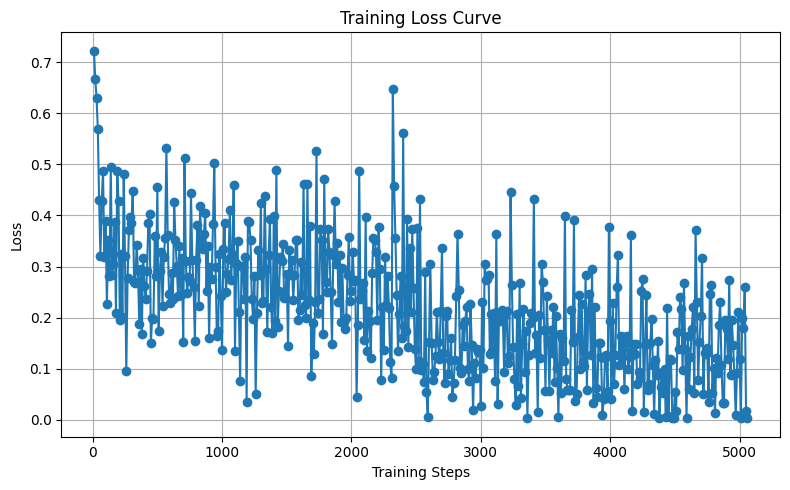

In [36]:
# Extract loss values from trainer state log history
log_history = trainer.state.log_history

# Get training steps and corresponding losses
train_steps = [entry["step"] for entry in log_history if "loss" in entry]
train_losses = [entry["loss"] for entry in log_history if "loss" in entry]

# Plot the training loss curve
plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


## Evaluating the Fine-Tuned BERT LLM
After training, evaluate the performance of fine-tuned BERT model using metrics: accuracy, F1 score, precision, and recall.

These metrics help to understand how well the model generalizes to unseen data.

In [20]:
# Evaluate model on the validation set
eval_results = trainer.evaluate()
print("Evaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")


Evaluation Results:
eval_loss: 0.2987
eval_accuracy: 0.9329
eval_f1: 0.9276
eval_precision: 0.9237
eval_recall: 0.9317
eval_runtime: 65.8039
eval_samples_per_second: 34.1930
eval_steps_per_second: 4.2850
epoch: 2.0000


### Bar-chart for Evaluation Metrics

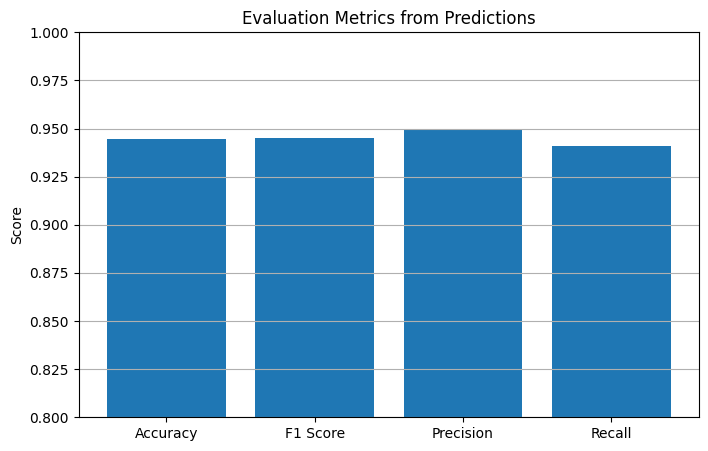

In [34]:
# Compute scores
acc = accuracy_score(y_true, y_preds)
f1 = f1_score(y_true, y_preds)
precision = precision_score(y_true, y_preds)
recall = recall_score(y_true, y_preds)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(["Accuracy", "F1 Score", "Precision", "Recall"], [acc, f1, precision, recall])
plt.ylim(0.8, 1.0)
plt.title("Evaluation Metrics from Predictions")
plt.ylabel("Score")
plt.grid(axis='y')
plt.show()

## Evaluate Model Predictions on Validation Set
To assess the fine-tuned model’s performance, I run predictions on the evaluation dataset.
The predicted labels are extracted from the model’s output logits and compared with the ground truth labels.
These predictions are used to compute evaluation metrics and generate visualizations.



In [31]:
# Run prediction on the evaluation set
predictions = trainer.predict(tokenized_datasets["eval"])

# Extract predicted and true labels
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Confirmation message
print("✅ Model predictions on the evaluation set completed.")

✅ Model predictions on the evaluation set completed.


### Confusion Matrix

To see how the model is making errors.

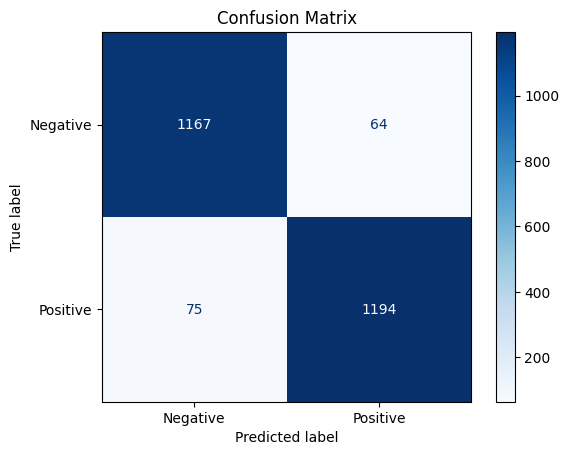

In [35]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Sample Predictions on Evaluation Data

To better understand how the fine-tuned BERT model performs, visualize predictions on a few random samples from the evaluation set.

Each sample shows the beginning of a review, the actual sentiment label, and the predicted label generated by the model.


In [45]:
# Separate positive and negative samples
positive_idxs = [i for i, d in enumerate(dataset["test"]) if d["label"] == 1]
negative_idxs = [i for i, d in enumerate(dataset["test"]) if d["label"] == 0]

# Take 2 samples from each
sampled_idxs = sample(positive_idxs, 2) + sample(negative_idxs, 2)

print("Sample predictions on evaluation set (balanced):\n")

for idx in sampled_idxs:
    text = dataset["test"][idx]["text"]
    true_label = dataset["test"][idx]["label"]

    # Tokenize and move to correct device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    label_str = lambda x: f"{x} ({'Positive' if x == 1 else 'Negative'})"

    print(f"Review: {text[:100]}...")
    print(f"True Label: {label_str(true_label)} | Predicted Label: {label_str(pred)}\n")


Sample predictions on evaluation set (balanced):

Review: Bring a box of Kleenex to this funny, engaging, and moving weeper. The two leading actors give tour ...
True Label: 1 (Positive) | Predicted Label: 1 (Positive)

Review: Discovering something, the journey is so much more fun, so much more surreal and so much more emotio...
True Label: 1 (Positive) | Predicted Label: 1 (Positive)

Review: This is probably one of the worst movies I have ever seen! The plot revolves around a man named Luth...
True Label: 0 (Negative) | Predicted Label: 0 (Negative)

Review: Fellow Giallo-fanatics: beware and/or proceed with caution  for this movie isn't exactly what it ap...
True Label: 0 (Negative) | Predicted Label: 0 (Negative)



## Predict Sentiment Using Fine-Tuned BERT Model
After training, the model can be tested by passing a custom input text to see if it correctly predicts the sentiment.

The input is tokenized and passed through the model, and the predicted sentiment (positive or negative) is returned based on the model's output logits.

In [37]:
def predict_sentiment(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Move inputs to same device as model
    device = model.device
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Put model in evaluation mode and disable gradient tracking
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted class
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    # Map to label
    label = "Positive" if predicted_class == 1 else "Negative"
    print(f"Predicted Sentiment: {label}")


In [38]:
predict_sentiment("The movie was absolutely amazing and thrilling!")


Predicted Sentiment: Positive


# Final Model Summary

The BERT model (`bert-base-uncased`) was fine-tuned on the IMDb sentiment analysis dataset.

-  Achieved **~93.2% accuracy** and **~92.8% F1 score** on the evaluation set.
- Training was completed over **2 epochs**, using `Trainer` API from Hugging Face.
- Additional evaluation metrics like **precision**, **recall**, and **confusion matrix** were computed and visualized.
- The training loss curve showed a stable decrease, indicating good convergence.
- Sample predictions on evaluation data were displayed to demonstrate model behavior.

This notebook demonstrates how **Large Language Models (LLMs)** like BERT can be adapted and fine-tuned for binary text classification tasks.
